In [1]:
import pandas as pd
import zipfile 
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import os
import re
from keras.utils import image_dataset_from_directory
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Resizing, Rescaling, Input, Dropout, BatchNormalization
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import tensorflow as tf
%matplotlib inline

In [ ]:
file_name = "data.zip"
zip_ref = zipfile.ZipFile(file_name, "r")
zip_ref.extractall("datos")
zip_ref.close()

In [200]:
desiredLength = 16000 * 8
def melSpectrogram(dir, file):
    #librosa.load(f'{dir}\{file}')
    signal, sr = librosa.load(f'{dir}/{file}', sr=16000)
    n_fft = 2048
    hop_length = 512
    padding = desiredLength - len(signal) #cantidad de tiempo que falta
    signal = np.concatenate([np.zeros((padding)), signal])
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.min)
    return power_to_db

In [2]:
data_dir = "audio"

In [3]:
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust","surprised"]
index = dict(enumerate(emotions,start=1))
for emotion in emotions:
    os.mkdir(f"{data_dir}/{emotion}")

In [4]:
for actor in os.listdir("./audio"):
    if actor not in emotions:
        for file in os.listdir(f"./audio/{actor}"):
            if file[-3:] != "png":
                matrix = melSpectrogram(f"./audio/{actor}/", file)
                emotion = int(file[:8][-2:])
                np.save(f'./audio/{index[emotion]}/{file[:-4]}', matrix)

NameError: name 'melSpectrogram' is not defined

A partir de aquí empieza el entrenamiento del modelo

In [2]:
dataset_dir = "./Dataset/"

In [45]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
b = np.random.choice(np.arange(10),size=4,replace=False)
print(b)
print(a[b])

[7 2 8 9]
[ 8  3  9 10]


In [62]:
emotions = ["happy", "sad", "fearful", "angry","surprised"]
full_data = []
labels    = []
for label in os.listdir(dataset_dir):
    intermediate = list()
    for file in os.listdir(dataset_dir+"/"+label):
        intermediate.append([np.load(dataset_dir +  label+"/" +file), emotions.index(label)])
    full_data.append(np.array(intermediate)[np.random.choice(np.arange(len(intermediate)), size=192, replace=False)])

c:\Users\lumin\anaconda3\envs\bot\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [63]:
full_data = np.array(full_data).reshape(192*5, 2)

In [64]:
np.random.shuffle(full_data)

In [5]:
trainInd = int(len(full_data) * 0.7)
train = full_data[:trainInd]
validation = full_data[trainInd:]

In [6]:
happy       = np.load('Dataset/happy/03-01-01-01-01-01-01.npy')
sad         = np.load('Dataset/sad/03-01-04-01-01-01-01.npy')
fearful     = np.load('Dataset/fearful/03-01-06-01-01-01-01.npy')
angry       = np.load('Dataset/angry/03-01-05-01-01-01-01.npy')
surprised   = np.load('Dataset/surprised/03-01-08-01-01-01-01.npy')

pruebas = np.array([happy, sad, fearful, angry, surprised])
labels  = np.array([0,1,2,3,4])

In [65]:
scaler = MinMaxScaler()
def separate(array):
    audios = []
    labels  =  []
    for audio, label in array:
        audios.append(np.expand_dims(audio, axis=2))
        labels.append(label)
    return [np.array(audios), np.array(labels)]

In [8]:
scaler.fit(pruebas.reshape(-1,1))
lista = list()
for i in pruebas[:]:
    lista.append(scaler.transform(i.reshape(-1,1)).reshape(128,train[0][0].shape[1],1))
pruebas = np.array(lista)

In [68]:
train = separate(full_data)
#validation = separate(validation)

In [69]:
scaler.fit(np.squeeze(train[0]).reshape(-1,1))

MinMaxScaler()

In [70]:
aux = []
for image in train[0]:
    aux.append(scaler.transform(np.squeeze(image).reshape(-1,1)).reshape((128,train[0][0].shape[1],1)))
aux = np.array(aux)

In [71]:
train[0] = aux

In [72]:
def generator(images, labels):
    for im,label in zip(images, labels):
        yield np.array(im),np.array(label)

In [73]:
model = Sequential()
model.add(Input((128, 251, 1)))
model.add(Resizing(224,224))

model.add(Conv2D(filters= 32, kernel_size= (3,3), activation="relu", padding= "same",strides=(1,1)))
model.add(Conv2D(filters= 32, kernel_size= (3,3), activation="relu", padding= "same",strides=(1,1)))

model.add( MaxPool2D(pool_size= (2,2),strides=(2,2)))
model.add( Conv2D(64,(3,3), activation="relu",padding= "same",strides=(1,1)))
model.add( Conv2D(64,(3,3), activation="relu",padding= "same",strides=(1,1)))

model.add(MaxPool2D(pool_size= (2,2),strides=(2,2)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))

model.add( MaxPool2D(pool_size= (2,2),strides=(2,2)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))
model.add( Conv2D(128,(3,3), activation="relu",padding= "same",strides=(1,1)))

model.add( MaxPool2D(pool_size= (2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 1)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 64)      36928     
                                                      

In [75]:
model.compile(loss="sparse_categorical_crossentropy", optimizer= Adam(learning_rate=0.00001), metrics=["accuracy"])

In [76]:
train[0].shape

(960, 128, 251, 1)

In [77]:
pruebas.shape

(5, 128, 251, 1)

In [89]:
historico = model.fit(x=train[0], y=train[1],batch_size=5, epochs=30)

Epoch 1/30
192/192 [==============================] - 6s 33ms/step - loss: 0.4231 - accuracy: 0.8344
Epoch 2/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3892 - accuracy: 0.8677
Epoch 3/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3972 - accuracy: 0.8604
Epoch 4/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3872 - accuracy: 0.8469
Epoch 5/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3804 - accuracy: 0.8625
Epoch 6/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3396 - accuracy: 0.8740
Epoch 7/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3573 - accuracy: 0.8656
Epoch 8/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3356 - accuracy: 0.8802
Epoch 9/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3500 - accuracy: 0.8656
Epoch 10/30
192/192 [==============================] - 6s 32ms/step - loss: 0.3433 - accura

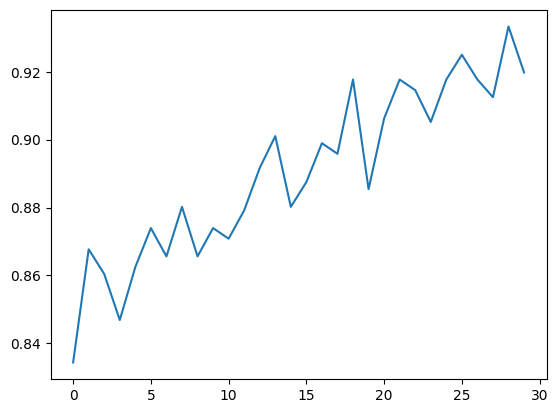

In [90]:
plt.plot(historico.history['accuracy'])

In [91]:
model.save('modelNoImage.h5')

In [69]:
train[0][0].shape

(128, 251, 1)

In [18]:
model.predict(train[0])

32/32 [==============================] - 1s 38ms/step


array([[0.3258511 , 0.1313594 , 0.13936415, 0.26327527, 0.1401501 ],
       [0.3258511 , 0.1313594 , 0.13936415, 0.26327527, 0.1401501 ],
       [0.3258511 , 0.1313594 , 0.13936415, 0.26327527, 0.1401501 ],
       ...,
       [0.3258511 , 0.1313594 , 0.13936414, 0.26327524, 0.1401501 ],
       [0.3258511 , 0.1313594 , 0.13936414, 0.26327524, 0.1401501 ],
       [0.3258511 , 0.1313594 , 0.13936414, 0.26327524, 0.1401501 ]],
      dtype=float32)

In [23]:
imgToPredict = train[0][0]

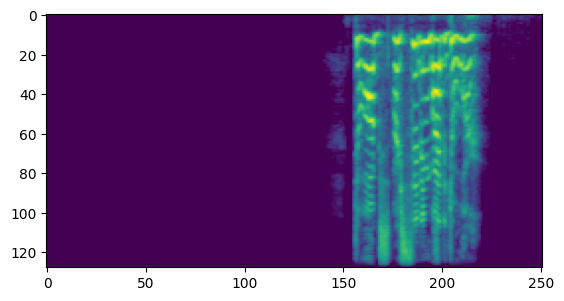

In [27]:
plt.imshow(imgToPredict)
plt.show()

In [33]:
model.predict(np.expand_dims(imgToPredict, axis=0))

1/1 [==============================] - 0s 19ms/step


array([[0.3258511 , 0.1313594 , 0.13936414, 0.26327524, 0.1401501 ]],
      dtype=float32)

In [35]:
model.predict(np.expand_dims(train[0][45], axis=0))

1/1 [==============================] - 0s 19ms/step


array([[0.3258511 , 0.1313594 , 0.13936414, 0.26327524, 0.1401501 ]],
      dtype=float32)